<a href="https://colab.research.google.com/github/ArjanL12/Cat-and-Dog-Image-Classifier/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-04-12 13:18:24--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M   105MB/s    in 0.2s    

2022-04-12 13:18:24 (105 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

### I provide 2 answers, the first handles things improperly/illogically but meets the arbitrary testing criteria. The second (below) handles things more logically but does not pass the testing criteria.

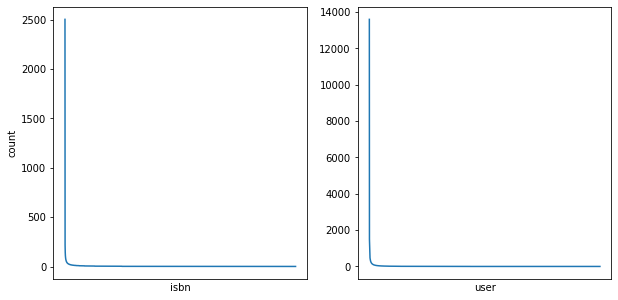

In [ ]:
#the majority of books and users have a small number of ratings
fig,axs = plt.subplots(1,2,figsize = (10,5))
axs[0].set(xlabel = 'isbn')
df_ratings.isbn.value_counts().plot(use_index = False, xticks = [], ylabel = 'count', ax = axs[0])
axs[1].set(xlabel = 'user')
df_ratings.user.value_counts().plot(use_index = False, xticks = [], ax = axs[1])

In [ ]:
#There should be a step here to handle ratings of 0 (read but not rated?). Dropping them or converting to mean makes would be logical.

1099999 of 1149780 entries excluded


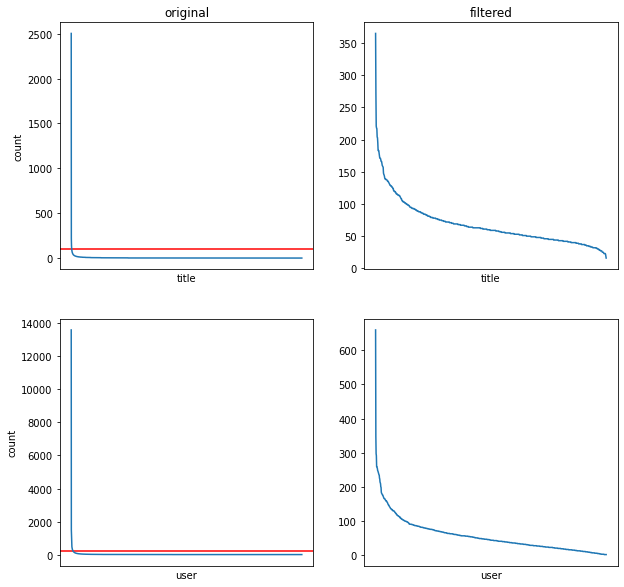

In [ ]:
#filter out low rating counts and check results. Remaining counts are < filter thresholds because the filters interact.
robust_ratings = df_ratings.loc[(~df_ratings.user.isin(df_ratings.user.value_counts().loc[lambda x: x<200].index))
                &(~df_ratings.isbn.isin(df_ratings.isbn.value_counts().loc[lambda x: x<100].index))].reset_index(drop = True)
print(df_ratings.shape[0] - robust_ratings.shape[0], 'of', df_ratings.shape[0], 'entries excluded')

fig,axs = plt.subplots(2,2, figsize = [10,10])
axs[(0,0)].axhline(y=100, color='r')
axs[(1,0)].axhline(y=200, color='r')
df_ratings.isbn.value_counts().plot(xticks = [], xlabel = 'title', ylabel = 'count', title = 'original', ax = axs[(0,0)])
axs[(1,0)].set_xlabel('user')
df_ratings.user.value_counts().plot(xticks = [], use_index = False, ylabel = 'count', ax = axs[(1,0)])
robust_ratings.isbn.value_counts().plot(xticks = [], xlabel = 'title', title = 'filtered', ax = axs[(0,1)])
axs[(1,1)].set_xlabel('user')
robust_ratings.user.value_counts().plot(xticks = [], use_index = False, ax = axs[(1,1)])

In [ ]:
#merge dataframes so we have title for each rating
book_ratings = pd.merge(robust_ratings,df_books, on = 'isbn')
#remove unneeded columns
book_ratings = book_ratings.drop(['author','isbn'], axis = 1)
print(book_ratings.shape)
book_ratings.head()

(49517, 3)


,user,rating,title
0,277427,10.0,Politically Correct Bedtime Stories: Modern Ta...
1,3363,0.0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,6.0,Politically Correct Bedtime Stories: Modern Ta...
3,12538,10.0,Politically Correct Bedtime Stories: Modern Ta...
4,13552,0.0,Politically Correct Bedtime Stories: Modern Ta...


In [ ]:
#drop duplicate book ratings (same book, different isbn) by same user
#note that THIS IS NOT THE MOST LOGICAL place (it should be done before filtering)
#or way to do this (can be done while grouping, and shouldn't arbitrarily keep the first value).
#It is only implemented here to meet the strange testing criteria
clean_ratings = book_ratings.drop_duplicates(['title','user'])
clean_ratings.shape

(49136, 3)

In [ ]:
#convert ratings to a 2d user by title matrix, with missing values (user didn't rate)
#set to 0 so user ratings for each title are all complete vectors that can be used to calculate distance
ratings2d = clean_ratings.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
ratings2d.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#convert 2d matrix to scipy sparse matrix. This is standard practice for sklearn NN input
#and speeds up calculations
ratings_csr = csr_matrix(ratings2d.values) 
ratings_csr

<673x888 sparse matrix of type '<class 'numpy.float32'>'
	with 12419 stored elements in Compressed Sparse Row format>

In [ ]:
#set up KNN model using brute algorithm and cosine similarity between rating vectors
model = NearestNeighbors(metric = 'cosine', algorithm= 'brute')
model.fit(ratings_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# function to return recommended books - this will be tested
# note that it is illogical to reverse the order of book recommendations, as the model outputs by distance (smaller is closer),
# not cosine distance (larger would closer)
def get_recommends(book = "Where the Heart Is (Oprah's Book Club (Paperback))"):
  distances, recommends = model.kneighbors(ratings2d.loc[book].values.reshape(1,-1), n_neighbors= 6)
  recommended_books = []
  book_list = []
  for i in range (0,len(recommends.flatten())):
    if i == 0:
      recommended_books.append(ratings2d.index[recommends.flatten()[i]])
    else:
      book_list.append([ratings2d.index[recommends.flatten()[len(recommends.flatten())-i]], distances.flatten()[len(recommends.flatten())-i]])
  recommended_books.append(book_list)

  return recommended_books


get_recommends()

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [["I'll Be Seeing You", 0.8016211],
  ['The Weight of Water', 0.77085835],
  ['The Surgeon', 0.7699411],
  ['I Know This Much Is True', 0.7677075],
  ['The Lovely Bones: A Novel', 0.7234864]]]

Use the cell below to test your function. The test_book_recommendation() function will inform you if you passed the challenge or need to keep trying.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉


## My second, more logical solution follows below. 
Note that this provides better recommendations, but will not pass the arbitrary testing criteria.

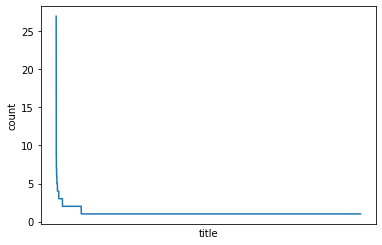

In [ ]:
df_books.title.value_counts().plot(xticks = [], xlabel = 'title', ylabel = 'count')

#a large number of books have different versions, so first step will be to get ratings by title instead of isbn

In [ ]:
#merge dataframes so we have title for each rating
book_ratings = pd.merge(df_ratings,df_books, on = 'isbn')
#remove unneeded columns
book_ratings = book_ratings.drop(['author','isbn'], axis = 1)
print(book_ratings.shape)
book_ratings.head()

(1031175, 3)


,user,rating,title
0,276725,0.0,Flesh Tones: A Novel
1,2313,5.0,Flesh Tones: A Novel
2,6543,0.0,Flesh Tones: A Novel
3,8680,5.0,Flesh Tones: A Novel
4,10314,9.0,Flesh Tones: A Novel


In [ ]:
#first convert ratings of 0 to NaN so they are not used in mean calculations
temp_ratings = book_ratings.replace({'rating':{0:np.nan}})
#then aggregate ratings for same title and user into a single mean rating
clean_ratings = temp_ratings.groupby(by = ['title', 'user'], as_index = False)['rating'].mean()
clean_ratings.rating.value_counts()

8.000000     91480
10.000000    70837
7.000000     66265
9.000000     60552
5.000000     45198
6.000000     31631
4.000000      7602
3.000000      5105
2.000000      2362
1.000000      1476
7.500000        88
8.500000        84
9.500000        63
6.500000        37
5.500000        14
4.500000         6
9.333333         6
9.666667         6
7.666667         4
8.666667         3
8.333333         2
6.333333         2
2.500000         2
1.500000         2
3.500000         1
6.666667         1
Name: rating, dtype: int64

In [ ]:
#get mean for each user
user_mean_ratings = clean_ratings.groupby('user', as_index = False)['rating'].mean()
#replace NaN with mean values
temp_ratings = clean_ratings.copy()
temp_ratings.rating = user_mean_ratings.rating[user_mean_ratings.user.isin(temp_ratings.user[temp_ratings.rating.isnull()])]
temp_ratings = temp_ratings.fillna(clean_ratings)
#drop ratings for users with no numeric ratings
final_ratings = temp_ratings.dropna()
print(clean_ratings.rating.isna().sum()-temp_ratings.rating.isna().sum(), 'ratings replaced')
print(clean_ratings.shape[0] - final_ratings.shape[0], 'of', clean_ratings.shape[0], 'ratings dropped')

17707 ratings replaced
625861 of 1026397 ratings dropped


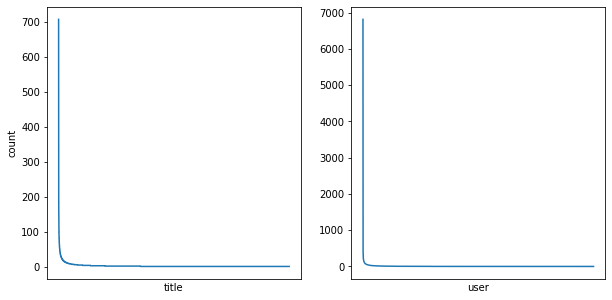

In [ ]:
#the majority of titles and users have a small number of ratings
fig,axs = plt.subplots(1,2,figsize = (10,5))
axs[0].set(xlabel = 'title')
final_ratings.title.value_counts().plot(use_index = False, xticks = [], ylabel = 'count', ax = axs[0])
axs[1].set(xlabel = 'user')
final_ratings.user.value_counts().plot(use_index = False, xticks = [], ax = axs[1])

392700 of 400536 entries excluded


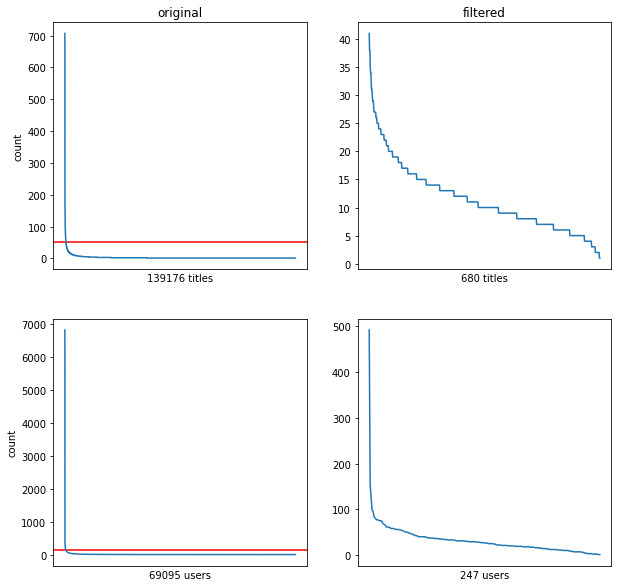

In [ ]:
#filter out low rating counts and check results. Remaining counts are < filter thresholds because the filters interact.
user_threshold = 150
title_threshold = 50
robust_ratings = final_ratings.loc[(~final_ratings.user.isin(final_ratings.user.value_counts().loc[lambda x: x<user_threshold].index))
                &(~final_ratings.title.isin(final_ratings.title.value_counts().loc[lambda x: x<title_threshold].index))].reset_index(drop = True)
print(final_ratings.shape[0] - robust_ratings.shape[0], 'of', final_ratings.shape[0], 'entries excluded')

fig,axs = plt.subplots(2,2, figsize = [10,10])
axs[(0,0)].axhline(y=title_threshold, color='r')
axs[(1,0)].axhline(y=user_threshold, color='r')
final_ratings.title.value_counts().plot(xticks = [], xlabel = f"{final_ratings.title.nunique()} titles", ylabel = 'count', title = 'original', ax = axs[(0,0)])
axs[(1,0)].set_xlabel(f"{final_ratings.user.nunique()} users")
final_ratings.user.value_counts().plot(xticks = [], use_index = False, ylabel = 'count', ax = axs[(1,0)])
robust_ratings.title.value_counts().plot(xticks = [], xlabel = f"{robust_ratings.title.nunique()} titles", title = 'filtered', ax = axs[(0,1)])
axs[(1,1)].set_xlabel(f"{robust_ratings.user.nunique()} users")
robust_ratings.user.value_counts().plot(xticks = [], use_index = False, ax = axs[(1,1)])

In [ ]:
#convert ratings to a 2d user by title matrix
robust_ratings2d = robust_ratings.pivot(index = 'title', columns = 'user', values = 'rating')
#remove user bias by subtracting the mean for each column(user), and then set missing values to 0 to complete the vectors so distance can be calculated
# robust_ratings2d = (robust_ratings2d - robust_ratings2d.mean()).fillna(0)
# or don't remove bias, because this may reflect the books that users choose to rate in the first place
robust_ratings2d = robust_ratings2d.fillna(0)

robust_ratings2d.head()

user,2276,4017,4385,6251,6543,6575,7346,8681,11676,12538,...,266226,268932,269566,270713,273113,274061,274301,275970,277427,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.000000,0.0,8.0,0.0,10.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,8.333333,0.0,0.0,0.0,9.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24 Hours,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,8.000000,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2nd Chance,7.5,0.0,0.0,0.0,6.000000,0.0,0.0,0.0,7.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3rd Degree,0.0,0.0,0.0,0.0,8.000000,0.0,0.0,0.0,8.689655,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#convert 2d matrix to scipy sparse matrix. This is standard practice for sklearn NN input
#and speeds up calculations
robust_ratings_csr = csr_matrix(robust_ratings2d.values) 
robust_ratings_csr

<680x247 sparse matrix of type '<class 'numpy.float64'>'
	with 7836 stored elements in Compressed Sparse Row format>

In [ ]:
#set up KNN model using brute algorithm and cosine similarity between rating vectors
model = NearestNeighbors(metric = 'cosine', algorithm= 'brute')
model.fit(robust_ratings_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# function to return recommended books
def get_recommends(book = "Where the Heart Is (Oprah's Book Club (Paperback))"):
  distances, recommends = model.kneighbors(robust_ratings2d.loc[book].values.reshape(1,-1), n_neighbors= 6)
  recommended_books = []
  book_list = []
  for i in range (0,len(recommends.flatten())):
    if i == 0:
      recommended_books.append(robust_ratings2d.index[recommends.flatten()[i]])
    else:
      book_list.append([robust_ratings2d.index[recommends.flatten()[i]], distances.flatten()[i]])
  recommended_books.append(book_list)
  return recommended_books

In [ ]:
get_recommends('The Queen of the Damned (Vampire Chronicles (Paperback))')

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
   0.5588810796361428],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5687106948787519],
  ['Interview with the Vampire', 0.6153385967433094],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.6244661919005947],
  ['Wifey', 0.6832075442518318]]]